# Proyecto Final: Detección de diabetes en pacientes

Este proyecto consiste en la aplicación de disticas técnicas de Machine Learning para intentar crear un clasificador que sea capaz de distinguir pacientes con diabetes tipo 2 de entre pacientes sin dicha enfermedad.

Para ello, he usado un conjunto de datos ubicados en la [siguiente dirección](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv)

In [10]:
# Imports de librerias necesarias
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.io as sio 
from logistic_regresion import *
from support_vector_machine import *
from neural_networks import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import math


In [35]:
# Función utilizada para leer un csv y extraer los datos
def load_csv(file_name):
    values = read_csv(file_name,header=None).values
    print("Los campos del dataset son: {}\n".format(values[0]))
    return values[1:].astype(float) # Eliminamos la primera fila ya que son el nombre de las columnas

In [36]:
# Importamos los datos
data = load_csv('data/diabetes.csv')
x_values = data[:,:-1]
y_values = data[:, -1]

print("El número de registros del conjunto de datos es: {} registros.".format(len(data)))

Los campos del dataset son: ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' 'Outcome']

El número de registros del conjunto de datos es: 768 registros.


Para las posteriores generaciones de curvas de aprendizaje y entrenamientos, vamos a dividir el conjunto total en tres partes:
+ En primer lugar tendremos el conjunto de entrenamiento, el cual supone un 70 por ciento el conjunto total
+ En segundo lugar, el 20 por ciento del conjunto se destinará a la validación
+ Por último, dejaremos el 10 por ciento restante para test

In [13]:
size = len(data)

# Entrenamiento (70%)
x_values_train = x_values[:int(size * 0.7)]
y_values_train = y_values[:int(size * 0.7)]

# Validacion (20%)
x_values_val = x_values[int(size * 0.7) : int(size * 0.7) + int(size * 0.2)]
y_values_val = y_values[int(size * 0.7) : int(size * 0.7) + int(size * 0.2)]

# Test (10%)
x_values_test = x_values[int(size * 0.7) + int(size * 0.2) :]
y_values_test = y_values[int(size * 0.7) + int(size * 0.2) :]

In [14]:
# Curvas de aprendizaje
def draw_learning_curves(x, y, x_val, y_val, model, reg=0, intervals=30):
    accs_train =  []
    accs_val = []
    x_values = []
    for i in range(2, len(x), intervals):
        x_values.append(i)
        
        model.train(x[:i], y[:i])
        acc_train = model.get_precision(x[:i], y[:i])
        acc_val = model.get_precision(x_val, y_val)

        accs_train.append(acc_train)
        accs_val.append(acc_val)

    plt.plot(x_values, accs_train, label='Train')
    plt.plot(x_values, accs_val, label='CrossVal')
    plt.legend()

## 1 - Máquina de soporte de vectores

Para esta parte, usaremos la máquina de soporte de vectores utilizado en la práctica 5.


La precisión con el conjunto de test es: 0.7692307692307693


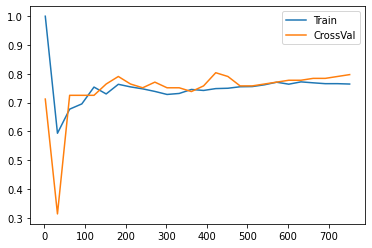

In [15]:
draw_learning_curves(x_values, y_values, x_values_val, y_values_val, SupportVectorMachine())

svm_model = SupportVectorMachine()

# Optimizamos la precisión probando con distintos parámetros y quedándonos con la mejor combinación que maximice la precisión con el conjunto de validación
svm_model.fit(x_values_train, y_values_train, x_values_val, y_values_val)

print("La precisión con el conjunto de test es: {}".format(svm_model.get_precision(x_values_test, y_values_test)))

Como podemos observar en las curvas, parece que la precisión se estabiliza del todo a partir de los 500 elementos.

## 2 - Regresión Logística

Para esta parte, usaremos el código usado para la práctica 3. Dicho código está preparado para realizar regresión logística multiclase. En nuestro caso, como solo disponemos de una clase, no usaremos el potencial completo de esta.

La precision con el conjunto de test es: 0.6282051282051282


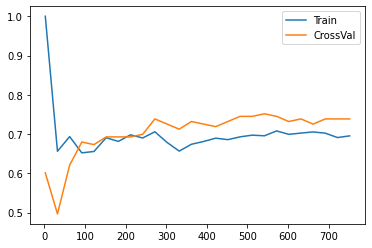

In [16]:
draw_learning_curves(x_values, y_values, x_values_val, y_values_val, LogisticRegresion())

log_reg_model = LogisticRegresion()

# Optimizamos la precisión probando con distintos parámetros y quedándonos con la mejor combinación que maximice la precisión con el conjunto de validación
log_reg_model.fit(x_values_train, y_values_train, x_values_val, y_values_val)

print("La precision con el conjunto de test es: {}".format(log_reg_model.get_precision(x_values_test, y_values_test)))

Como podemos observa en este caso, aunque la precisión se mantiene medianamente constante durante todo el desarrollo de la curva, si es cierto que no parece muy concluyente, por lo que podemos llegar a pensar que, en este caso, se necesitarían más datos para alcanzar una precisión óptima.

## 3 - Regresión Logística (Sklearn)

A modo de experimentación, usaremos la regresión logística de la librería de sklearn. Esta dispone de multitud de parámetros configurables.

La precision con el conjunto de test es: 0.8076923076923077


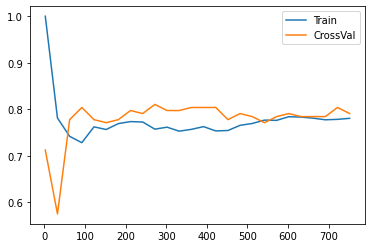

In [29]:
# Creamos la clase para que la funcion de dibujado de la curva de aprendizaje no sea modificada
class SKLogisticRegressionAdapter:
    def __init__(self):
        self.model = None

    def train(self, x, y):
        self.model = LogisticRegression(
            fit_intercept=True, 
            penalty='l2', 
            tol=1e-5, 
            C=0.8, 
            solver='newton-cg', 
            max_iter=75,
            warm_start=True
        )
        self.model.fit(x, y)

    def get_precision(self, x, y):
        return accuracy_score(y, self.model.predict(x))

draw_learning_curves(x_values, y_values, x_values_val, y_values_val, SKLogisticRegressionAdapter())
sk_log_regresion = SKLogisticRegressionAdapter()
sk_log_regresion.train(x_values_train, y_values_train)

print("La precision con el conjunto de test es: {}".format(sk_log_regresion.get_precision(x_values_test, y_values_test)))


Como se puede observar, la precisión se mantiene bastante constante a partir de los 600 datos, aproximadamente. También podemos observar que la precisión es bastante superior que usando la regresión logística creada para las prácticas. Esto puede ser debido a los algoritmos que sklearn dispone para clasificar, que pueden llegar a ser más eficiente que los que disponemos.

## 3 - Redes Neuronales

Por último, usaremos las redes neuronales programadas para el desarrollo de la práctica 4. Para mejor entendimiento, he forzado a crear siempre las mismas matrices de thetas, debido a que la aleatoriedad puede provocar precisiones distintas, ocasionando posibles incosistencias de cara a las conclusiones.

La precision con el conjunto de test es: 0.6410256410256411


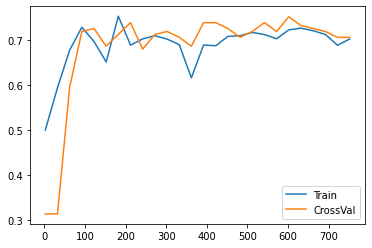

In [8]:
draw_learning_curves(x_values, y_values, x_values_val, y_values_val, NeuralNetWork())

nn_model = NeuralNetWork()

# Optimizamos la precisión probando con distintos parámetros y quedándonos con la mejor combinación que maximice la precisión con el conjunto de validación
nn_model.fit(x_values_train, y_values_train, x_values_val, y_values_val)

print("La precision con el conjunto de test es: {}".format(nn_model.get_precision(x_values_test, y_values_test)))

Como también podemos observar, las precisiones se estabilizan desde los 500 elementos.

## 4 - Precisiones y conclusión final

| Técnicas                       | Precisión |
|--------------------------------|-----------|
| SVM \(Support Vector Machine\) | 76\.92%   |
| Regresión Logística            | 62\.82%   |
| Regresión Logística (sklearn)  | 80\.76%   |
| Redes Neuronales               | 64\.10%   |

Como conclusión, podemos deducir que la regresión logística parece la mejor técnica que soluciona este problema. Aunque sea algo menos preciso, parece que la técnica de svm también funciona.

Tras observar detenidamente las curvas de aprendizaje, he llegado a la conclusión de que, aunque parecen que las precisiones tienen a estabilizarse aproximadamente a partir de los 500 elementos, podría ser que se necesitasen más datos de cara a llegar a las máximas precisiones, debido a que el tamaño total del conjunto son aproximadamente 200 elementos más. Esto quire decir que es posible que si hubiesen más registros, esa curva llegase finalmente a un máximo. Por tanto, creo que el conjunto de datos del que dispongo es algo pequeño en cuanto a número de muestras o en cuanto a características de cada individuo.

Por último, y como última conclusión, la mejor precisión que hemos obtenido parece ser bastante insuficiente para el uso médico, puesto que hay bastante margen de error. Por tanto, creo que, aunque la precisión no es baja, tampoco es lo suficientemente alta como para fiarnos de cada predicción y, por tanto, no es seguro utilizarlo como único método para comprobar si el paciente tiene diabetes o no.